# Set Up

General import of all the necessary libraries and modules. Introduction, purpose and aim is right after.

In [1]:
!pip install deap

     |████████████████████████████████| 160 kB 5.4 MB/s 


In [2]:
import random
import math
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import torch

from numpy import genfromtxt
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin, bin_to_gray
from deap import creator, base, tools, algorithms
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume

from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin

# INTRODUCTION, PURPOSE AND AIM
The main purpose of this jupyter notebook is to experiment with the deap learning library to optimise feed forward multi-layer perceptron models weight by means of genetic optimisation.

The following function has been used inorder to be learned and optimised by a FFMLP network with two hiddden layers to approximate: 

**y = sin(3.5(x1)+1.0)cos(5.5(x2))** in bounds **x1, x2 in [-1, 1]**

Reason behind this function being chosen is that it is a rather complex illustration as a 3d plane between -1 and 1. I thought that by a normal FFMLP 2 hidden layer network would be rather hard task to learn and approximate by it self alone. However with the use of Geneetic Algorithms (GA) the same amount of epochhs could be used to approximate the function by the network a lot more efficiently.
I use the deap library in order to optimise the NN.

Throughout the notebook i have used markup cells and comments to explain the code of what happens where. A indepth outlook on the functions IS NOT PROVIDED as there is well documented documentation of the deap library online [1]

I have split the notebook into "questions" that outline what the collections of cells will do.

[1] - https://deap.readthedocs.io/en/master/

# SECTION - 1.1

This collection of cells is simply used to visualise the function that is to be estimated by the neural network, stricktly between -1 and 1 respectively.
Visualisations have been done with the use of **NumPy and matplotlib**.

In [3]:
# Declare a function that will return the value of the objective function.
def objective_func(x1, x2):
  return (np.sin((3.5 * x1) + 1)) * (np.cos(5.5 * x2))

In [ ]:
# Quick test of solution for confirming
objective_func(0.5,0.5)

-0.35277016278519596

Visualise the function in 3d surface plot, in given range [-1, 1]
use of numpy for numbers us recommended. [3]


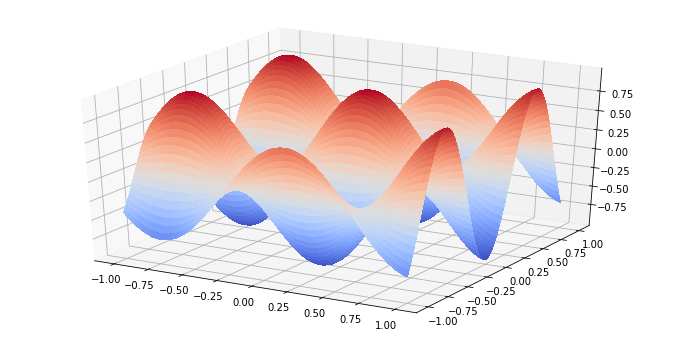

In [4]:
# 100 values between -1.0 and 1.0 whice are uniformly distributed.
xrange = np.linspace(-1.0, 1.0, 100)
yrange = np.linspace(-1.0, 1.0, 100)

# Using meshgrid, create mesh of X, Y. Find Z coordinates using the objective function.
X, Y = np.meshgrid(xrange, yrange)
Z = objective_func(X, Y)

# Changing to np array
z = np.array(Z)

# Plot
fig = plt.figure(figsize=(26,6))

# Surface plot with color grading and color bar 
ax = fig.add_subplot(1,2,1, projection='3d')
p = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)

# SECTION - 1.2

Here the aim is to prepare the data for training and testing.
Randomly generated are 1100 samples for x1 and x2 within [-1, 1], which are used to calculate the corresponding y values. 
Once randomly selected, all x1, x1, and y values are appended to train and testing variables then saved to .dat files in form [x1, x2, y] as one data point.
Furthermore, the training and testing arrays are then changed to **torch.tensors** however that was done after visualisation in the later question. note its important to change it to **torch.tensor** before training and testing, as it will work best with the pytorch library.

In [5]:
train_data = open("train.dat", "w+")
train_arr = []

test_data = open("test.dat", "w+")
test_arr = []

samples = []

for i in range(1100):
  x1 = random.uniform(-1, 1)
  x2 = random.uniform(-1, 1)
  y = objective_func(x1, x2)
  samples.append([x1, x2, y])

print(len(samples))

for i in range(1000):
  selected = samples[random.randint(0,(1100-i-1))]
  samples.remove(selected)
  train_data.write(str(selected[0]) + " " + str(selected[1]) + " " + str(selected[2]) +"\n")
  train_arr.append(selected)
  print(selected)

train_data.close()

for sample in samples:
  test_data.write(str(sample[0]) + " " + str(sample[1]) + " " + str(sample[2]) +"\n")
  test_arr.append(sample)
  print(sample)

test_data.close()

1100
[-0.30127161500632504, -0.7316525964217835, 0.03457132184385739]
[0.2579108221366597, 0.6853567813747845, -0.7651164555212623]
[-0.3203072993565834, 0.30071126855231745, 0.010027149901575843]
[-0.13039567370841199, 0.8078845801779329, -0.13747569702310522]
[0.7863248930168296, -0.5729853120542392, 0.573285970792582]
[-0.4559586037273524, -0.056277340453075864, -0.5345467109079693]
[0.9358802512310653, -0.5610270836673579, 0.9046890580074263]
[-0.4098799344304498, -0.9061358405224227, -0.11285273979792254]
[0.23259482261220144, -0.010706140808847353, 0.9688696387266759]
[-0.010746491733884866, 0.5272448020296903, -0.7966977020984827]
[-0.3236408834514204, -0.8860460079356041, -0.021199231006806263]
[-0.8800078900066053, -0.27560463123261303, -0.047971957642803494]
[0.8111775893994604, -0.9313152718163857, -0.25594572326320925]
[0.9029576778194668, 0.6047095284213497, 0.837036826955108]
[-0.5910253170794875, -0.954767676920043, -0.4497740262827909]
[-0.16319159915415615, 0.707482328

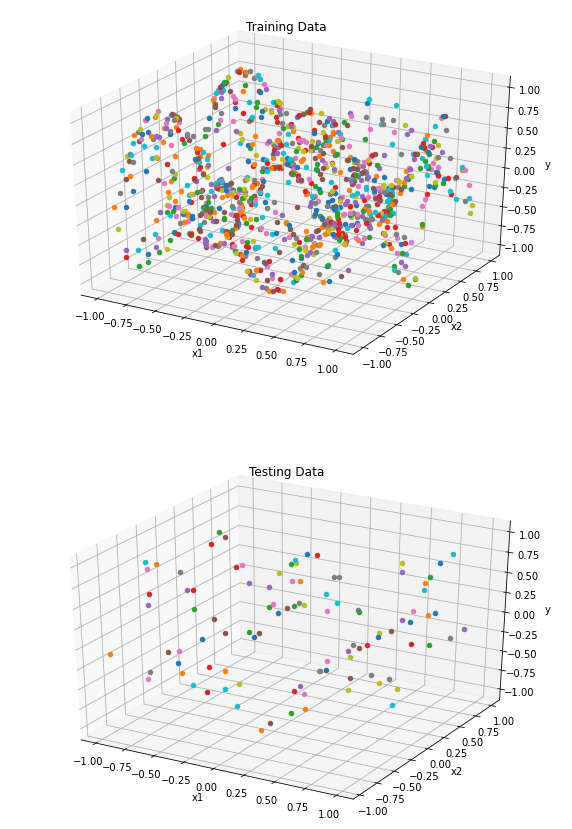

In [6]:
fig = plt.figure(figsize=(10,15))
train_fig = fig.add_subplot(2, 1, 1, projection='3d')
train_fig.set_title("Training Data")
train_fig.set_xlabel("x1")
train_fig.set_ylabel("x2")
train_fig.set_zlabel("y")
for training_sample in train_arr:
  train_fig.scatter3D(float(training_sample[0]), float(training_sample[1]), float(training_sample[2]))

test_fig = fig.add_subplot(2, 1, 2, projection='3d')
test_fig.set_title("Testing Data")
test_fig.set_xlabel("x1")
test_fig.set_ylabel("x2")
test_fig.set_zlabel("y")
for testing_sample in test_arr:
  test_fig.scatter3D(float(testing_sample[0]), float(testing_sample[1]), float(testing_sample[2]))

# SECTION - 1.3

**Architecture explained:**
These series of cells are used to develop the pytorch neural network architecture. It has been chosen for the neural entwork to have **6 hidden neurons in each of the hidden layers**. There is a **threshold/bias connection for all nodes and the output node**. The activation function to be used is a **sigmoid function** within the **hidden neurons** and a **linear activtion function** on the **output neuron**. Here the nn is develoed.

Architecture details:

- Input layer       : 2 neuron
- Output layer      : 1 neuron
- Hidden layer 1    : 6 neurons
- Hidden layer 2    : 6 neurons

- Hidden layer activation function: Sigmoid
- Output layer activation function: Linear

- Threshold/bias connection for all hidden nodes



In [7]:
# Declaring variables for the network 
lower_bound = -20
upper_bound = 40

# Network variables
input_size = 2
output_size = 1
h_layers = 6

In [8]:
# Set up the network
# :: By default the bias is set to true between all layers except inputs

class Net(torch.nn.Module):

    # Initialise one hidden layer and one output layer
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden)  # hidden layer 1
        self.hidden_2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer 2
        self.out = torch.nn.Linear(n_hidden, n_output)        # output layer

    # Connect up the layers: Input passes through the hidden, then the sigmoid, then the output layer
    def forward(self, x):
        x = torch.sigmoid(self.hidden_1(x))      # Pass through hidden with sigmoid acc function 
        x = torch.sigmoid(self.hidden_2(x))      # Pass through hidden_2 with sigmoid acc function
        x = self.out(x)                          # Pass througn linear out layer
        return x

In [9]:
# Declare and initialise the network, visualise in most basic way the architecture of the network
net = Net(n_feature=input_size, n_hidden=h_layers, n_output=output_size) 
print(net) 

Net(
  (hidden_1): Linear(in_features=2, out_features=6, bias=True)
  (hidden_2): Linear(in_features=6, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
# Shape is (6, 2) - hidden_1
print(net.hidden_1.weight)
print(net.hidden_1.weight.shape)
print("\n")

# Shape is (6, 6) - hidden_2
print(net.hidden_2.weight)
print(net.hidden_2.weight.shape)
print("\n")

# Shape is (1, 6) - out layer
print(net.out.weight)
print(net.out.weight.shape)
print("\n")

print(net.out.bias)
print(net.out.bias.shape)

Parameter containing:
tensor([[-0.0898,  0.4393],
        [ 0.4239,  0.3773],
        [ 0.0365,  0.4978],
        [ 0.6595,  0.4554],
        [-0.2281,  0.1536],
        [-0.4694, -0.0718]], requires_grad=True)
torch.Size([6, 2])


Parameter containing:
tensor([[-0.4004,  0.3643,  0.0613, -0.1890,  0.1211,  0.0039],
        [-0.0452,  0.0832, -0.3959, -0.1197, -0.3650, -0.2559],
        [-0.3746,  0.3738, -0.3778,  0.0045, -0.3036,  0.1173],
        [ 0.0396, -0.2687, -0.2758,  0.2044,  0.1884, -0.0377],
        [-0.3651, -0.0301,  0.2483, -0.2978,  0.3011,  0.1719],
        [ 0.1689, -0.2455,  0.1765, -0.3092,  0.1514, -0.3219]],
       requires_grad=True)
torch.Size([6, 6])


Parameter containing:
tensor([[ 0.1555,  0.1361, -0.1335, -0.0885,  0.0403,  0.2394]],
       requires_grad=True)
torch.Size([1, 6])


Parameter containing:
tensor([-0.2258], requires_grad=True)
torch.Size([1])


# SECTION - 1.4

The purpose here is to two functions **weightsOutofNetwork** and **weightsInNetwork**.

- **weightsOutofNetwork**: Extracts all the weights of the network and puts them into one list vraible; returns that list.
- **weightsInNetwork**: Takes the input of a list of all weighst of the network and uses them to set the weights of the network.

Tests have been written to check if the weihts are retrived and inserted into the netwrok correctly.

In [10]:
# Extracts all the weights of the network
# Puts them into one list
# Output : returns said list
# Can defineyly make it more dynamic by adding a parameter neural network instead of relating to the local()/global() of the python environment.
def weightsOutOfNetwork():

    # Retrive all possible weights & cahnge them to a list
    # Reshape to total number of weights
    hidden_1_w = net.hidden_1.weight
    h_1_w = hidden_1_w.reshape(12).tolist()

    hidden_2_w = net.hidden_2.weight
    h_2_w = hidden_2_w.reshape(36).tolist()

    out_w = net.out.weight
    o_w = out_w.reshape(6).tolist()

    # Retrive all possible weights for bias nodes 
    # Reshape to total number of weights
    hidden_1_w_bias = net.hidden_1.bias
    h_1_w_b = hidden_1_w_bias.reshape(6).tolist()

    hidden_2_w_bias = net.hidden_2.bias
    h_2_w_b = hidden_2_w_bias.reshape(6).tolist()

    out_w_bias = net.out.bias
    o_w_b = out_w_bias.reshape(1).tolist()

    # Join everything together
    output = h_1_w + h_1_w_b + h_2_w + h_2_w_b + o_w + o_w_b

    # Return the wanted list of weights
    return output              

In [ ]:
# Test for weightOutOfNetwork function
weightsOutOfNetwork()[:25]

[0.5967603325843811,
 -0.42975741624832153,
 0.14019988477230072,
 0.04371108487248421,
 0.5553761720657349,
 -0.38915500044822693,
 -0.012936891056597233,
 -0.6073784828186035,
 -0.6578972339630127,
 0.44634202122688293,
 0.29363396763801575,
 0.6142523884773254,
 0.14748598635196686,
 -0.6306079030036926,
 0.4915585219860077,
 -0.5254613757133484,
 -0.424155592918396,
 0.7016764879226685,
 0.4023759961128235,
 0.10435657948255539,
 -0.33359378576278687,
 0.06620628386735916,
 -0.17711134254932404,
 0.32187625765800476,
 0.26002129912376404,
 0.16444244980812073,
 0.11473710089921951,
 0.05836671218276024,
 0.08781807869672775,
 -0.0914289727807045,
 0.2402670830488205,
 0.2735580801963806,
 0.10944660753011703,
 0.370446115732193,
 -0.18484239280223846,
 0.16199134290218353,
 0.23925845324993134,
 -0.3840140402317047,
 -0.3403073847293854,
 -0.051923248916864395,
 0.2807161211967468,
 0.14903920888900757,
 0.2519204914569855,
 -0.030528316274285316,
 0.08876162767410278,
 -0.37392771

In [ ]:
# Simple test, using slicing can extract the according weights and biases
# Based on the previous function created
# Can defo make it a function in relation to the network thats inputted, just needs some changing.
print("--- ALL WEIGHTS FOR HIDDEN_1 from INP ---")
print(weightsOutOfNetwork()[0:12])
print("\n")

print("--- ALL WEIGHTS FOR bias HIDDEN_1 ---")
print(weightsOutOfNetwork()[12:18])
print("\n")

print("--- ALL WEIGHTS FOR HIDDEN_2 from H_1 ---")
print(weightsOutOfNetwork()[18:54])
print("\n")

print("--- ALL WEIGHTS FOR bias HIDDEN_2 ---")
print(weightsOutOfNetwork()[54:60])
print("\n")

print("--- ALL WEIGHTS FOR OUT LAYER from H_2 ---")
print(weightsOutOfNetwork()[60:66])
print("\n")

print("--- ALL WEIGHTS FOR OUT LAYER bias ---")
print(weightsOutOfNetwork()[66:67])
print("\n")

--- ALL WEIGHTS FOR HIDDEN_1 from INP ---
[0.5967603325843811, -0.42975741624832153, 0.14019988477230072, 0.04371108487248421, 0.5553761720657349, -0.38915500044822693, -0.012936891056597233, -0.6073784828186035, -0.6578972339630127, 0.44634202122688293, 0.29363396763801575, 0.6142523884773254]


--- ALL WEIGHTS FOR bias HIDDEN_1 ---
[0.14748598635196686, -0.6306079030036926, 0.4915585219860077, -0.5254613757133484, -0.424155592918396, 0.7016764879226685]


--- ALL WEIGHTS FOR HIDDEN_2 from H_1 ---
[0.4023759961128235, 0.10435657948255539, -0.33359378576278687, 0.06620628386735916, -0.17711134254932404, 0.32187625765800476, 0.26002129912376404, 0.16444244980812073, 0.11473710089921951, 0.05836671218276024, 0.08781807869672775, -0.0914289727807045, 0.2402670830488205, 0.2735580801963806, 0.10944660753011703, 0.370446115732193, -0.18484239280223846, 0.16199134290218353, 0.23925845324993134, -0.3840140402317047, -0.3403073847293854, -0.051923248916864395, 0.2807161211967468, 0.14903920888

In [11]:
# input : list of all weihts (loaw) list of ALL weights of the network (weightsOutOfNetwork)
# Uses them to set the weights of the network
# Again can make to reference a network.
def weightsIntoNetwork(loaw):
    
    # Hidden 1 LAYER weights and respective BIAS weights
    hidden_1_w_new = np.asarray(loaw[0:12])
    hidden_1_bias_new = np.asarray(loaw[12:18])

    # Hidden 2 LAYER weights and respective BIAS weights
    hidden_2_w_new = np.asarray(loaw[18:54])
    hidden_2_bias_new = np.asarray(loaw[54:60])

    # Out LAYER weights and respective BIAS weight
    out_w_new = np.asarray(loaw[60:66])
    out_bias_new = np.asarray(loaw[66:67])

    # Resise accordingly to fit network weights
    hidden_1_w_reshaped = torch.nn.Parameter(torch.from_numpy(hidden_1_w_new.reshape(6, 2)))
    hidden_1_bias_reshaped = torch.nn.Parameter(torch.from_numpy(hidden_1_bias_new.reshape(6)))
    hidden_2_w_reshaped = torch.nn.Parameter(torch.from_numpy(hidden_2_w_new.reshape(6, 6)))
    hidden_2_bias_reshaped = torch.nn.Parameter(torch.from_numpy(hidden_2_bias_new.reshape(6)))
    out_w_reshaped = torch.nn.Parameter(torch.from_numpy(out_w_new.reshape(1, 6)))
    out_bias_reshaped = torch.nn.Parameter(torch.from_numpy(out_bias_new.reshape(1)))

    # Apply the new weights to the network    
    net.hidden_1.weight = hidden_1_w_reshaped
    net.hidden_1.bias = hidden_1_bias_reshaped
    net.hidden_2.weight = hidden_2_w_reshaped
    net.hidden_2.bias = hidden_2_bias_reshaped
    net.out.weight = out_w_reshaped
    net.out.bias = out_bias_reshaped


In [12]:
# Test for the given question 
# Works fine - need to remember to reset runtime as ive run it one too many times
def test_in_out_functions():

    # Collects every weight of the netwrok and initialises allWeights variable
    allWeights = weightsOutOfNetwork()
    
    # Print INPUT TO HIDDEN_1 weights [0:12] - Reference last test in doc
    for i in range(0,12):
      print(allWeights[i])

    # Change 3 of those weights
    # Can make it such that its random, will work better
    allWeights[0:3] = [0.5, 0.5, 0.5]
    # Check to see if len corresponds correctly
    print(len(allWeights))

    # Insert all weights back in the network
    weightsIntoNetwork(allWeights)

    # Use weightsOutofNetwork to retrive again
    allWeights = weightsOutOfNetwork()

    # Print again to check
    # Can change this to check both arrays and just bold the difference
    for i in range(0,12):
        if i < 3:
            bold_weight = "\033[1m" + str(allWeights[i]) + "\033[0m"
            print(bold_weight)
        else:
            weight = allWeights[i]
            print(weight)

test_in_out_functions()

0.5673551559448242
-0.3297309875488281
0.7054766416549683
-0.434152752161026
0.11340713500976562
-0.2862514555454254
0.679419219493866
0.6554109454154968
0.25467368960380554
0.5564071536064148
0.38717198371887207
-0.36623114347457886
67
0.5
0.5
0.5
-0.434152752161026
0.11340713500976562
-0.2862514555454254
0.679419219493866
0.6554109454154968
0.25467368960380554
0.5564071536064148
0.38717198371887207
-0.36623114347457886


# SECTION 1.5 

Binary coded GA with gray coding of optimising the weights of the neural network to fit the function by minimising mean squared error on the training dataset. loss of the training function is then to be used as the fitness of an individual within the GA.
The evaluation function will extract weights from the chromosome and insert all weights in the network using the WeightsIntoNetwork() function previously defined.


In [13]:
#### For remembering #######
#      input_size = 2      #
#      output_size = 1     #
#      h_layers = 6        #
############################

# GA variables
popSize = 75
generations = 150
numOfBits = 30

# Chromosome length = inp -> h1, h1 -> h2, h2-> out
chromosome_length = (((input_size + 1) * h_layers) + ((h_layers + 1) * h_layers) + ((h_layers + 1) * output_size)) * numOfBits

# GA variables
dimension   = int(chromosome_length/numOfBits) # Number of decision variable x 
dspInterval = 10
nElitists   = 1 # Number of elite individuals selected
omega       = 5
crossPoints = 2 # Variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) # Bit mutate prob
mutateprob  = .1 # Mutation prob
maxnum      = 2**numOfBits # Absolute max size of number coded by binary list 1,0,0,1,1,....

In [14]:
# This is just to check of the chromosome length mateches the amount of dimensions
# 2010 / 30 = 67 => dimensions
print(f"Chromosome length based on network: {chromosome_length}") 

Chromosome length based on network: 2010


In [15]:
# Loss function is Mean Squared Error
loss_function = torch.nn.MSELoss()
running_loss = 0.0

# Loss values for Training & Testing
loss_values_train = []
loss_values_test = []

In [16]:
# Turning array to ndarray
train_set = np.array(train_arr)
test_set = np.array(test_arr)

# Separating to input and output arrays
i_train = train_set[:, 0:2]
o_train = train_set[:, 2:]
i_test = test_set[:, 0:2]
o_test = test_set[:, 2:]

# Turning input and output arrays to tensors
i_train = torch.as_tensor(i_train).type(torch.float64)
i_test = torch.as_tensor(i_test).type(torch.float64)
o_train = torch.as_tensor(o_train).type(torch.float64)
o_test = torch.as_tensor(o_test).type(torch.float64)

print(i_train.dtype)
print(i_test.shape)
print(o_train.shape)
print(o_test.shape)

torch.float64
torch.Size([100, 2])
torch.Size([1000, 1])
torch.Size([100, 1])


In [ ]:
# Gray coding input needs to be changed to binary and then to real normalised, then return
def normalise(individual):

  # Change list into string
  #values = np.array(individual)
  values_string = ''.join(map(str, individual))

  # Apply gray coding bit string representation to get binary representation 
  values_decoded_bin = gray_to_bin(values_string)

  # Need to make list again as str wont work and then to nparray
  values_decoded_bin = np.array([int(char) for char in values_decoded_bin])

  # print(values_decoded_bin)

  # Reshape to size 67x30 which is 2010 bits 
  values_decoded_bin = values_decoded_bin.reshape(dimension, numOfBits)


  temp_arr = []
  for i in values_decoded_bin:
      indasstring=''.join(map(str, i))
      sum = int(indasstring, 2)
      value_list = lower_bound + (upper_bound * (sum/maxnum))
      temp_arr.append(value_list)
  temp_arr = np.array(temp_arr)

  print(temp_arr)

  return temp_arr

In [ ]:
def evaluate(individual):

    # Extract weights from the chromosome and normalises
    real_value = normalise(individual)

    # Insert all weights in the network
    weightsIntoNetwork(real_value)

    # Predicts result of inputs using neural net
    out = net(i_train)

    # MSE Loss function
    loss = loss_function(out, o_train)

    return loss.item(),

In [ ]:
# DEAP registration functionality for each individual
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, numOfBits*dimension)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint) # using uniform better? or Two point
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selBest, fit_attr='fitness')

In [17]:
# Loss values for Training & Testing
loss_values_train = []
loss_values_test = []

In [ ]:
# Generate population and calculate fitnesses
pop = toolbox.population(n=popSize)
fitnesses = list(map(toolbox.evaluate, pop))

# Assign fitnesses to individuals
for ind, fit in zip(pop, fitnesses):
  ind.fitness.values = fit

# Retrieves fitnesses of all individuals as an integer
fitnesses = [ind.fitness.values[0] for ind in pop]
print(f"This list of fitnesses: {list(fitnesses)}")

# Generational counter
g = 0

while g < generations:
  g = g + 1
  print("-- Generation %i --" % g)

  offspring = tools.selBest(pop, nElitists) + toolbox.select(pop, len(pop))
  offspring = [toolbox.clone(ind) for ind in offspring]

  for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
    # make pairs of all (even,odd) in offspring
    if random.random() <= crossProb:
      toolbox.mate(ind1, ind2)
      
      del ind1.fitness.values, ind2.fitness.values

  for child in offspring:
    if random.random() < mutateprob:
      toolbox.mutate(child)

  # Evaluate the individuals with an invalid fitness
  invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  # Replace population with offspring
  pop = offspring 
  loss_values_train.append(tools.selBest(pop, 1)[0].fitness.values)

  # Extract the best individual from the new population
  best_ind = tools.selBest(pop, 1)[0]
  val_best_individual = normalise(best_ind)

  # Using the previous function, out best ind update weights of NN
  weightsIntoNetwork(val_best_individual)

  # Predicts result of inputs using NN
  test_output = net(i_test)

  #MSE Loss function
  test_loss = loss_function(test_output, o_test)
  loss_values_test.append(test_loss.item())

  # Every 10 generations record and print
  if g % dspInterval == 0:

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    
print("-- End of (successful) evolution --")
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

# Apply best individual to the network?
final_val_best_individual = normalise(best_ind)
# Using the previous function, out best ind update weights of NN
weightsIntoNetwork(val_best_individual)


Streaming output truncated to the last 5000 lines.
 -19.54588003  -9.40583277   2.23221701  17.24869329  -8.72305408
   4.47622329  14.91611965  18.87423255  17.61925641 -10.71131647
  17.76967537  -9.95195981  -0.83316457  -5.94243787  14.05437909
  -9.6535987   12.97308415   3.30778841 -18.01552683 -10.04730292
 -15.28062426  12.62184579 -12.19993871 -12.72681918  16.36178993
   2.65976191  -8.42533946]
[ -6.9040766    7.28413682  -4.0152511    6.77773833  -4.76967186
 -19.09259927  12.31730502 -17.3911785   -8.19798693   1.8083046
 -11.9109178  -10.97702429 -17.36527752  17.13471133 -13.55473127
  -4.8588489  -12.49523621 -13.97397384   8.52418367  10.29813729
  -6.86259847   9.86071672  18.01806916   9.64989521  -3.01156454
  12.09373899 -11.48772828 -11.61782876  15.6491458    1.03256855
  -3.13421685   3.94923631 -18.48069713 -16.04731515  -6.86387699
   8.93634982 -14.16775696  -6.07289609  12.28492863   3.6953276
   6.80464257  -5.88814683 -12.93692514   6.44302446  -2.2163916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


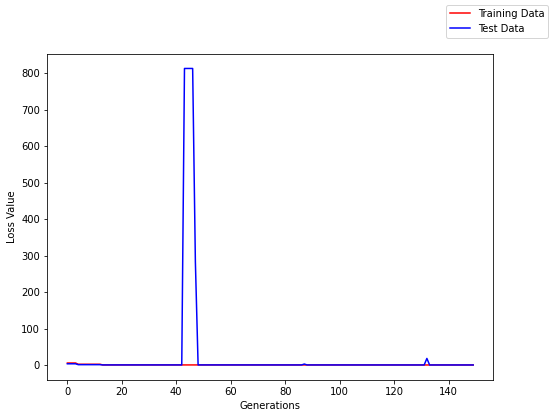

In [ ]:
loss_plots = plt.figure(figsize=(8, 6))
loss_test_plot = loss_plots.add_subplot(111)
loss_training_plot = loss_plots.add_subplot(111)
loss_training_plot.set_xlabel('Generations')
loss_test_plot.set_xlabel('Generations')
loss_training_plot.set_ylabel('Loss Value')
loss_test_plot.set_ylabel('Loss Value')

loss_training_plot.plot(np.array(loss_values_train), 'r')
loss_test_plot.plot(np.array(loss_values_test), 'b')
loss_plots.legend(["Training Data", "Test Data"])

# SECTION - 1.6

Here a creation of a 3D surface plot of the function is implemented within the range of [-1, 1]. To do this i first compute the networks output for a grid of values uniformly covering the range. This is provided by the nn prediction.
NOTE - This will not be great given that its the simplest form of the netwrok with NO OPTIMISATION added to it besides using the base deap library. This is done much more efficiently later on in the later questions.

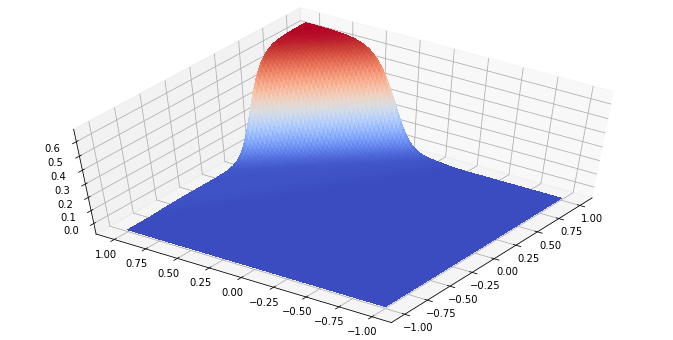

In [ ]:
# Uniform distribution for x1 and x2
xrange_net = np.linspace(-1.0, 1.0, 100)
yrange_net = np.linspace(-1.0, 1.0, 100)

# Meshgrid torch
X, Y = np.meshgrid(xrange_net, yrange_net)

# Make list point 
grid = np.c_[X.ravel(), Y.ravel()]

# Change to tensor
grid = torch.nn.Parameter(torch.from_numpy(grid)).type(torch.float64)

# Predict the points 
output = net(grid)

# Detach and flatten
output = output.detach().flatten()

# Change output to 2d array 
output = output.reshape(100, 100)

# Change to np array
output = np.array(output)

# Plotting
fig = plt.figure(figsize=(26,6))

# Surface plot with color grading and color bar 
ax = fig.add_subplot(1,2,1, projection='3d')
p = ax.plot_surface(X,Y,output, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
p = ax.view_init(55, 215)




# SECTION - 1.7

Here a function is created that takes a lost of weighst and returns the chromosome in gray coding. The function checks if weights need to be pished back into the range of [-20,20]. A series of test has been done to confirm if that is the case.


In [ ]:
from sympy.combinatorics.graycode import bin_to_gray

In [ ]:
bit_num = '110000000000000000000000000000'

In [18]:
#   input  : an individual weight float number
#   output : gray coded bit representation of inputted number of length 30 bits
def float_to_bin_gray(number):

    remainder = 0

    nor_num = number
    orig_number = nor_num - lower_bound
    orig_number = orig_number/upper_bound
    orig_number = orig_number*maxnum

    og_rounded = round(orig_number)
    og_int = int(og_rounded)

### BIN REPRESENTATION

    bin_rep = bin(og_int).lstrip("0b")

    bin_rep_str = str(bin_rep)

    length = len([int(digit) for digit in bin_rep_str])

#### CHECKS

    if(length < 30):
        remainder = 30 - length
        output = '0'*remainder + bin_rep_str
        return output

    elif(length > 30):
        bin_rep_temp = bin_rep_str[:-1]
        output = str(bin_rep_temp)
        return output

    else:
        return bin_rep_str



In [19]:
# input   : Takes in a list of weights - output from weightsOutOfNetwork
# returns : Chromsome (list of bits in gray codeing)
# NOTES   :
#         - Reverse the process to make it from a number to a bit list.
#         - Needs to check if weights need to be pushed back into range
#         - each weight is to be encoded into 30 bit lengths dimension*numOfBits
#         - 2010 bits (67x30) - can reshape that
def weights_to_chromosome_gray(list_of_weights):

    out_str_bin =''

    for i in list_of_weights:
      weight_float_value = i
       
      if(weight_float_value > 20 or weight_float_value < -20):
        # If outside set to 20 or -20
        out_str_bin = out_str_bin + float_to_bin_gray(float(-20.0))

      else:
        out_str_bin = out_str_bin + float_to_bin_gray(weight_float_value)

    greydec = bin_to_gray(out_str_bin)

    gray_code_arr = np.array([int(digit) for digit in greydec])

    return gray_code_arr
    

In [ ]:
# Testing for the above

# Extracting weights
n = weightsOutOfNetwork()
b = n
print(type(n))

# Show them
print(n)
print("\n")

# Call function to change to grey bit string rep (2010 bits) & show
gray_bits_arr = weights_to_chromosome_gray(n)
print(gray_bits_arr)
print("\n")

# Show putting back chromosome as weights
test_chrom_weights = normalise(gray_bits_arr)
print(test_chrom_weights)
print("\n")



<class 'list'>
[-6.904076598584652, 7.284136824309826, -4.015251100063324, 6.777738332748413, -4.765822216868401, 3.1018460541963577, -12.323117963969707, -18.314275071024895, -1.8020131066441536, -1.808304637670517, 11.91091775894165, 10.977024249732494, 17.365277484059334, -17.134711369872093, 13.554731272161007, 8.737962394952774, -12.145013622939587, -14.006063267588615, -17.355298921465874, 16.382121667265892, -6.862598471343517, 9.860716722905636, 17.52233050763607, 14.453110061585903, -1.1611904576420784, 8.100628331303596, -11.117244884371758, 17.503489032387733, -6.731745563447475, 5.217431411147118, 3.1342168152332306, -16.049819216132164, -11.397673785686493, 8.327684849500656, -5.4660362005233765, 13.876150138676167, 14.167756922543049, 5.802103914320469, 12.284928634762764, 3.6956027522683144, -11.991858519613743, 14.58405539393425, -2.2322170436382294, 6.9364020973443985, -0.8699657022953033, 4.476043879985809, -14.246520437300205, -4.273786544799805, 9.761437624692917, 1

In [ ]:
# Change first 3 out of range and see if change 

b[0:3] = [22.54, -23.954, 21.793]
print(b)
test = weights_to_chromosome_gray(b)
print(test)
t = normalise(test)
# print(t)


[22.54, -23.954, 21.793, 6.777738332748413, -4.765822216868401, 3.1018460541963577, -12.323117963969707, -18.314275071024895, -1.8020131066441536, -1.808304637670517, 11.91091775894165, 10.977024249732494, 17.365277484059334, -17.134711369872093, 13.554731272161007, 8.737962394952774, -12.145013622939587, -14.006063267588615, -17.355298921465874, 16.382121667265892, -6.862598471343517, 9.860716722905636, 17.52233050763607, 14.453110061585903, -1.1611904576420784, 8.100628331303596, -11.117244884371758, 17.503489032387733, -6.731745563447475, 5.217431411147118, 3.1342168152332306, -16.049819216132164, -11.397673785686493, 8.327684849500656, -5.4660362005233765, 13.876150138676167, 14.167756922543049, 5.802103914320469, 12.284928634762764, 3.6956027522683144, -11.991858519613743, 14.58405539393425, -2.2322170436382294, 6.9364020973443985, -0.8699657022953033, 4.476043879985809, -14.246520437300205, -4.273786544799805, 9.761437624692917, 17.71298062056303, 2.6339637488126755, 18.046995624

# SECTION - 1.8

Here to improve the neural network learning procedure such that it does not read and learn only one of the local minima of the data. embeded Rprop learning is implemented as a local search method (lifetime learning). Lamarckian learning appraoch is implemented. 30 itterations of local search n each generation. Hyperparameter choices are justified as comments. Error accross the generations is shown as well as a 3D surfae plot of the funtion implemented and given by the neural network.
At the bottom of the collection of cells there is proof that embeded Rprop learning is implemented as a local search method (lifetime learning). shoing a exponential increase in approximation of the objective function.

In [20]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin, weights=[])

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, numOfBits*dimension)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:

# Gray coding input needs to be changed to binary and then to real normalised, then return
def normalise(individual):

  # Change list into string
  #values = np.array(individual)
  values_string = ''.join(map(str, individual))

  # Apply gray coding bit string representation to get binary representation 
  values_decoded_bin = gray_to_bin(values_string)

  # Need to make list again as str wont work and then to nparray
  values_decoded_bin = np.array([int(char) for char in values_decoded_bin])

  # Reshape to size 67x30 which is 2010 bits 
  values_decoded_bin = values_decoded_bin.reshape(dimension, numOfBits)  

  temp_arr = []

  for i in values_decoded_bin:
      # print(f"i : {i}")
      indasstring=''.join(map(str, i))
      sum = int(indasstring, 2)
      value_list = lower_bound + (upper_bound * (sum/maxnum))
      
      temp_arr.append(value_list)

  temp_arr = np.array(temp_arr)

  print(temp_arr)

  return temp_arr

In [ ]:
def evaluate(individual):

    # Extract weights from the chromosome and normalises
    real_value = normalise(individual)

    # Insert all weights in the network
    weightsIntoNetwork(real_value)

    # Predicts result of inputs using neural net
    out = net(i_train)

    # MSE Loss function
    loss = loss_function(out, o_train)

    return loss.item(),

In [ ]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint) # using uniform better? or Two point
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selBest, fit_attr='fitness')

In [ ]:
# Loss values for Training & Testing
loss_values_train = []
loss_values_test = []

# Generate population and calculate fitnesses
pop = toolbox.population(n=popSize)
fitnesses = list(map(toolbox.evaluate, pop))


# Generational counter
g = 0

while g < generations:
  g = g + 1
  print("-- Generation %i --" % g)

  # For the beg of population
  
  for ind in pop:

    # Put ind into network
    # Gets me the weighst 
    norm = normalise(ind)

    # put weights into netwrok
    weightsIntoNetwork(norm)

    # Set optimizer with current ind weighss
    optimizer = torch.optim.Rprop(net.parameters(), lr=0.01)


    # iteration of 30 for learning 
    for i in range(30):
      out = net(i_train)
      loss_optimizer = loss_function(out, o_train)
      optimizer.zero_grad()
      loss_optimizer.backward()
      optimizer.step()

    # Put changes in network into ind 
    life_time_weights = weightsOutOfNetwork()
    ind[:] = weights_to_chromosome_gray(life_time_weights)
    
    # Calc new fitness
    # fit = toolbox.evaluate(ind)

    print(f"type of ind in changing for loop: {type(ind)}")
    ind.fitness.values = toolbox.evaluate(ind)


  ##################################

  offspring = tools.selBest(pop, nElitists) + toolbox.select(pop, len(pop))
  offspring = [toolbox.clone(ind) for ind in offspring]

  for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
    # make pairs of all (even,odd) in offspring
    if random.random() <= crossProb:
      toolbox.mate(ind1, ind2)
      
      del ind1.fitness.values, ind2.fitness.values

  for child in offspring:
    if random.random() < mutateprob:
      toolbox.mutate(child)

  # Evaluate the individuals with an invalid fitness
  invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  # Replace population with offspring
  pop = offspring 

  # record the loss of train from best ind
  loss_values_train.append(tools.selBest(pop, 1)[0].fitness.values)

  # Extract the best individual from the new population
  best_ind = tools.selBest(pop, 1)[0]

  val_best_individual = normalise(best_ind)

  # Using the previous function, out best ind update weights of NN
  weightsIntoNetwork(val_best_individual)

  # Predicts result of inputs using NN
  test_output = net(i_test)

  #MSE Loss function
  test_loss = loss_function(test_output, o_test)
  loss_values_test.append(test_loss.item())

  # Every 10 generations record and print
  if g % dspInterval == 0:

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    
print("-- End of (successful) evolution --")
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

# Apply best individual to the network?
final_val_best_individual = normalise(best_ind)
# Using the previous function, out best ind update weights of NN
weightsIntoNetwork(val_best_individual)


Streaming output truncated to the last 5000 lines.
  -4.48582608 -10.37813179   4.65876374  -3.36953953 -10.55338591
   2.31313165  10.64489171 -17.2629768    2.95191053  -0.40017772
   2.27828484   9.95890453   8.08911309   2.07628593  12.4946196
  -7.79129907 -19.85508122  14.72165585  -9.77381088  19.86305386
 -16.9456448  -15.5061442  -16.85304407  13.48853912  10.90242367
  -9.2764711   16.41329143  12.74935916  -6.92614153 -13.23378392
  -6.16958067  -4.96643875  16.51316766  19.31754924  -0.42442378
  -8.74006484  19.12102241  -4.61586833 -19.09367774 -14.71270103
  -5.41732937   7.62179676 -17.9488055   12.51202583  -5.58908362
 -20.          -6.55430395 -17.04908144   2.79890068  10.93092334
   1.97547212  -0.83581526  -7.8493819    0.18631462  -0.26584446
  -2.26774845   1.20265521]
type of ind in changing for loop: <class 'deap.creator.Individual'>
[  5.09365503  -0.61449744 -10.06077942  10.74022379   4.76600152
  11.22483999  -8.55410907  12.95849953   3.60809751  10.92035

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


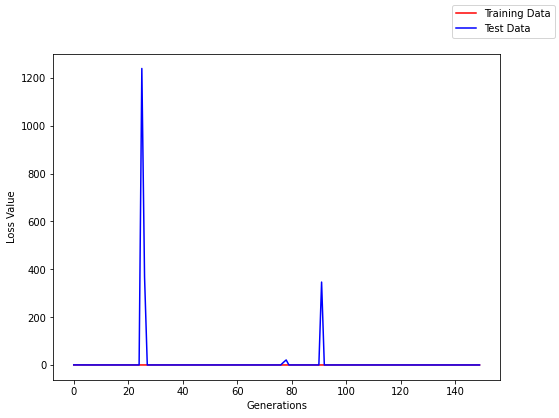

In [ ]:
# This cell to be used for visualisations, same way as before
loss_plots = plt.figure(figsize=(8, 6))
loss_test_plot = loss_plots.add_subplot(111)
loss_training_plot = loss_plots.add_subplot(111)
loss_training_plot.set_xlabel('Generations')
loss_test_plot.set_xlabel('Generations')
loss_training_plot.set_ylabel('Loss Value')
loss_test_plot.set_ylabel('Loss Value')

loss_training_plot.plot(np.array(loss_values_train), 'r')
loss_test_plot.plot(np.array(loss_values_test), 'b')
loss_plots.legend(["Training Data", "Test Data"])

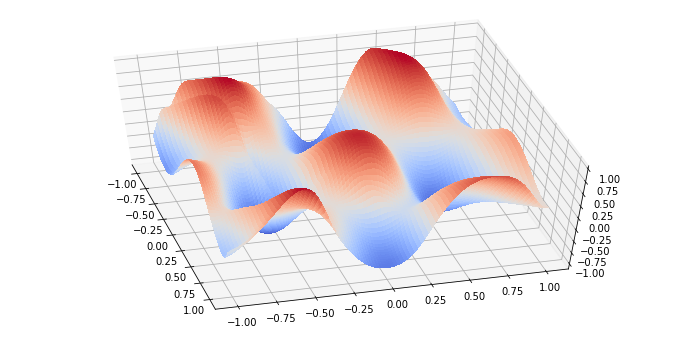

In [ ]:
# This cell to be used for the 3-d plot to see how it does
# Uniform distribution for x1 and x2
xrange_net = np.linspace(-1.0, 1.0, 100)
yrange_net = np.linspace(-1.0, 1.0, 100)

# Meshgrid torch
X, Y = np.meshgrid(xrange_net, yrange_net)

# Make list point 
grid = np.c_[X.ravel(), Y.ravel()]

# Change to tensor
grid = torch.nn.Parameter(torch.from_numpy(grid)).type(torch.float64)

# Predict the points 
output = net(grid)

# Detach and flatten
output = output.detach().flatten()

# Change output to 2d array 
output = output.reshape(100, 100)

# Change to np array
output = np.array(output)

# Plotting
fig = plt.figure(figsize=(26,6))

# Surface plot with color grading and color bar 
ax = fig.add_subplot(1,2,1, projection='3d')
p = ax.plot_surface(X,Y,output, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
p = ax.view_init(55, 345)




As you can see above, using embedded rporp learning, within thesame amount of epochs/generations, the neural network was able to evaluate and approximate the objective function much better by minimising each indals fitness, doing an elitist selection, then using such selection to select the best individual and reproduce offspring for the next generation.

# SECTION - 1.9

Here the baldwinian learning approach is used to replace the lamarckian approach done in the previous question. Thesame approach is done within the cells to illustarte the evaluation and the learning process of the neural network. Both the results are compared to those obtained in the previous section. This approach is not complete, as there is some bug that i am trying to fix.

In [21]:
# Gray coding input needs to be changed to binary and then to real normalised, then return
def normalise(individual):

  # Change list into string
  values_string = ''.join(map(str, individual))

  # Apply gray coding bit string representation to get binary representation 
  values_decoded_bin = gray_to_bin(values_string)

  # Need to make list again as str wont work and then to nparray
  values_decoded_bin = np.array([int(char) for char in values_decoded_bin])

  # Reshape to size 67x30 which is 2010 bits 
  values_decoded_bin = values_decoded_bin.reshape(dimension, numOfBits)  

  temp_arr = []

  for i in values_decoded_bin:
      # print(f"i : {i}")
      indasstring=''.join(map(str, i))
      sum = int(indasstring, 2)
      value_list = lower_bound + (upper_bound * (sum/maxnum))
      
      temp_arr.append(value_list)

  temp_arr = np.array(temp_arr)

  print(temp_arr)

  return temp_arr

In [22]:
def evaluate(individual):

    # Extract weights from the chromosome and normalises
    real_value = normalise(individual)

    # Insert all weights in the network
    weightsIntoNetwork(real_value)

    # Predicts result of inputs using neural net
    out = net(i_train)

    # MSE Loss function
    loss = loss_function(out, o_train)

    return loss.item(),

In [23]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint) # using uniform better? or Two point
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selBest, fit_attr='fitness')

In [25]:
from deap.tools.selection import selBest

# Loss values for Training & Testing
loss_values_train = []
loss_values_test = []

# Generate population and calculate fitnesses
pop = toolbox.population(n=popSize)
fitnesses = list(map(toolbox.evaluate, pop))

# Assign fitnesses to individuals
for ind, fit in zip(pop, fitnesses):
  ind.fitness.values = fit

# Retrieves fitnesses of all individuals as an integer
fitnesses = [ind.fitness.values[0] for ind in pop]
print(f"This list of fitnesses: {list(fitnesses)}")

# Generational counter
g = 0


# optimizer = torch.optim.Rprop(net.parameters(), lr=0.01)

while g < generations:

  g = g + 1
  print("-- Generation %i --" % g)

  # Baldwin approach #######
  
  for ind in pop:

    # Put ind into network
    # Gets me the weighst 
    norm = normalise(ind)

    # put weights into netwrok
    weightsIntoNetwork(norm)

    # Set optimizer with current ind weighss
    optimizer = torch.optim.Rprop(net.parameters(), lr=0.01)

    # iteration of 30 for learning 
    for i in range(30):
      out = net(i_train)
      loss_optimizer = loss_function(out, o_train)
      optimizer.zero_grad()
      loss_optimizer.backward()
      optimizer.step()

    # Put changes in network into ind 
    # life_time_weights = weightsOutOfNetwork()
    # ind[:] = weights_to_chromosome_gray(life_time_weights)
    
    # Calc new fitness
    # fit = toolbox.evaluate(ind)

    # print(f"type of ind in changing for loop: {type(ind)}")
    # ind.fitness.values = toolbox.evaluate(ind)
    ind.fitness.values = loss_optimizer,


  ##################################


  offspring = tools.selBest(pop, nElitists) + toolbox.select(pop, len(pop))
  offspring = [toolbox.clone(ind) for ind in offspring]

  for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
    # make pairs of all (even,odd) in offspring
    if random.random() <= crossProb:
      toolbox.mate(ind1, ind2)
      
      del ind1.fitness.values, ind2.fitness.values

  for child in offspring:
    if random.random() < mutateprob:
      toolbox.mutate(child)


  # Evaluate the individuals with an invalid fitness
  invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  # Replace population with offspring
  pop = offspring 

  loss_values_train.append(tools.selBest(pop, 1)[0].fitness.values)

  # Extract the best individual from the new population
  best_ind = tools.selBest(pop, 1)[0]

  # Normalise
  weights_of_best = normalise(best_ind)

  # Put weights into the best sol
  weightsIntoNetwork(weights_of_best)

  # Predicts result of inputs using NN
  test_output = net(i_test)

  #MSE Loss function
  test_loss = loss_function(test_output, o_test)
  loss_values_test.append(test_loss.item())

  # Every 10 generations record and print
  if g % dspInterval == 0:

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    
print("-- End of (successful) evolution --")
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


Streaming output truncated to the last 5000 lines.
   0.97970314  18.64714175 -10.36995992  -8.99832226 -15.27251337
  -5.83376359  14.8747088   -9.26791821  -3.22245598 -18.45249299
  14.46587555 -14.2440746   15.82410857  -2.11431928 -11.90272216
  -7.13330846  -8.25018898   1.78470433  -5.30596014  12.10417606
 -12.40606595   6.15396068 -12.00407665  -1.27270497  15.60101457
  11.72971483  10.79195272  -1.6885937   15.13983298 -14.00051378
   4.4604335  -11.31267108]
[ 14.71121851  13.90353177   8.81174881  12.66343318   7.12010227
 -18.89150206  13.71930022  13.30169272 -12.37129766  -5.84694088
   0.63485805  -7.02229578  -5.175904     0.04649162  18.23583234
   8.64158817  13.89265217  15.38202025  -1.01905555  11.06769443
  -4.12853472 -15.30967791  15.31311452   1.21343683  12.56474536
   1.427617    11.19128242  -0.21337271  -7.18663681  -7.21542533
  -0.88649694  15.76966092   7.11142246 -13.82789627 -15.64350858
   0.97970314  18.64714175 -10.36995992  -8.99832226 -15.272513

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


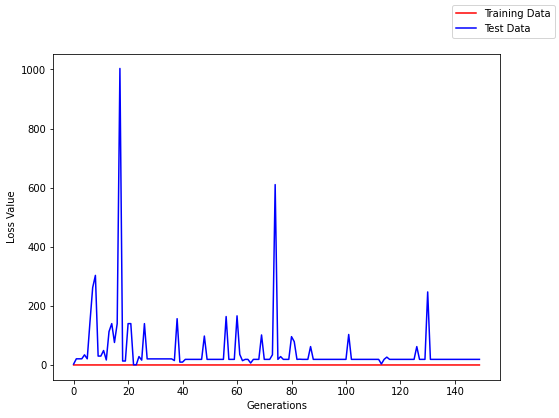

In [26]:
# This cell to be used for visualisations, same way as before
loss_plots = plt.figure(figsize=(8, 6))
loss_test_plot = loss_plots.add_subplot(111)
loss_training_plot = loss_plots.add_subplot(111)
loss_training_plot.set_xlabel('Generations')
loss_test_plot.set_xlabel('Generations')
loss_training_plot.set_ylabel('Loss Value')
loss_test_plot.set_ylabel('Loss Value')

loss_training_plot.plot(np.array(loss_values_train), 'r')
loss_test_plot.plot(np.array(loss_values_test), 'b')
loss_plots.legend(["Training Data", "Test Data"])

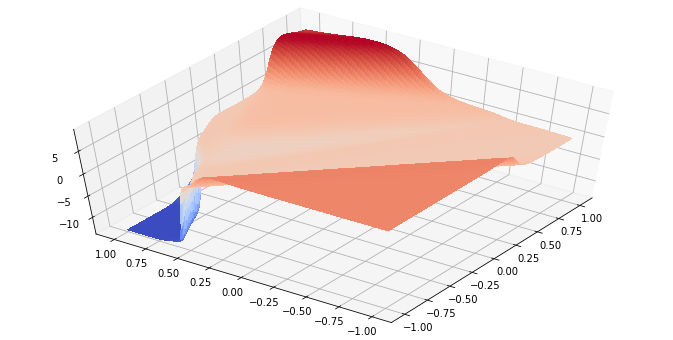

In [27]:
# 3d plot
# Uniform distribution for x1 and x2
xrange_net = np.linspace(-1.0, 1.0, 100)
yrange_net = np.linspace(-1.0, 1.0, 100)

# Meshgrid torch
X, Y = np.meshgrid(xrange_net, yrange_net)

# Make list point 
grid = np.c_[X.ravel(), Y.ravel()]

# Change to tensor
grid = torch.nn.Parameter(torch.from_numpy(grid)).type(torch.float64)

# Predict the points 
output = net(grid)

# Detach and flatten
output = output.detach().flatten()

# Change output to 2d array 
output = output.reshape(100, 100)
# XX = X.reshape(-1, 1)
# YY = Y.reshape(-1, 1)

# Change to np array
output = np.array(output)
# XX = np.array(XX)
# YY = np.array(YY)

# Shapes test
# print(XX.shape, YY.shape, output.shape)
# print(XX[1][0], YY[1][0], output[1][0])

# Plotting
fig = plt.figure(figsize=(26,6))

# Surface plot with color grading and color bar 
ax = fig.add_subplot(1,2,1, projection='3d')
# ax.scatter3D(X, Y, output, cmap='Greens');
# p = ax.plot_surface(X, Y, output)
p = ax.plot_surface(X,Y,output, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
p = ax.view_init(55, 215)